**Fake News Detection using Machine Learning Classification models**

The dataset from Kaggle. 
https://www.kaggle.com/c/fake-news/data?select=train.csv
1. Download or Use the attach file, move it into /content/train.csv
2. Then, Run all to see all the result of each models

Models: SVC, Logistic Regression, Linear SVC, Decision Tree, Gradient Boosting and Stochastic Gradient Descent. 

The result show accuracy scores, confusion matrix, ROC curve of each model and a comparative ROC curves plot.

In [ ]:
import sys  
!{sys.executable} -m pip install contractions

     |████████████████████████████████| 287 kB 15.3 MB/s 
     |████████████████████████████████| 106 kB 73.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, RocCurveDisplay

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import nltk
import contractions
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVC, LinearSVC
from time import time
from pprint import pprint
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score

**Data Pre processing**

In [ ]:
# loading the dataset to a pandas DataFrame
news_dataset = pd.read_csv('/content/train.csv', sep=',')


In [ ]:
# print the first 5 rows of the dataframe
news_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
#df_fake = pd.read_csv("/content/Fake.csv")
##df_true = pd.read_csv("/content/True.csv")
#df_fake["label"] = 1
#df_true["label"] = 0
#test_dataset = pd.concat([df_fake, df_true], axis =0 )
#test_dataset = test_dataset.fillna('')
#test_dataset['content'] = test_dataset['title']+' '+test_dataset['text'] + ' ' + test_dataset['subject']

In [ ]:
# replacing the null values with empty string
news_dataset = news_dataset.fillna('')

In [ ]:
# merging the author name and news title
news_dataset['content'] = news_dataset['author']+' '+news_dataset['title'] + ' ' + news_dataset['text']
#print(news_dataset['content'])

Pre Processiong Functions

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def expandContraction(content):
  """Expand contractions in the content"""
  return contractions.fix(content)

def to_lower(content):
  """Convert every characters in the content to lower case"""
  return content.lower()

def remove_punctuation(content):
  """Remove punctuations from the content"""
  return re.sub('[%s]' % re.escape(string.punctuation), '' , content)

def remove_digit(content):
  """Remove words and digits containing digits from the content"""
  return re.sub('\w*\d\w*','',content)

def remove_stopwords(content):
  """Remove stopwords from the content"""
  stop_words = stopwords.words('english')
  return " ".join([word for word in content.split() if word not in stop_words])

def remove_email(content):
  """Rephrase email addresses into 'emailadd' in the content"""
  return re.sub('\S+@\S+(?:\.\S+)+', 'emailadd', content)

def remove_url(content):
  """Rephrase urls into 'urladd' in the content"""
  return re.sub('https?://\S+|www\.\S+', 'urladd', content)

def stem_words(content):
  """Stem words in the content"""
  return " ".join([stemmer.stem(word) for word in content.split()])

def lemmatize_words(content):
  """lemmatize words in the content"""
  return " ".join([lemmatizer.lemmatize(word) for word in content.split()])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preprocess(content):
  # Replace apostrophe with single quote
  content = content.replace("’","'")
  # Expand Contractions
  #content = expandContraction(content)
  # Lower Case
  content = to_lower(content)
  # Remove Punctuations
  content = remove_punctuation(content)
  # Remove words and digits containing digits
  content = remove_digit(content)
  # Remove Stopwords
  content = remove_stopwords(content)
  # Email and Url removal
  content = remove_email(content)
  content = remove_url(content)
  # Stemming
  content = stem_words(content)
  # Lemmatization
  content = lemmatize_words(content)

  
  return content

In [ ]:
news_dataset['content'] = news_dataset['content'].apply(preprocess)

In [ ]:
#test_dataset['content'] = test_dataset['content'].apply(preprocess)

In [ ]:
print(news_dataset['content'][0])

darrel lucu hous dem aid didnt even see comey letter jason chaffetz tweet hous dem aid didnt even see comey letter jason chaffetz tweet darrel lucu octob subscrib jason chaffetz stump american fork utah imag courtesi michael jolley avail creativ commonsbi licens apolog keith olbermann doubt worst person world week–fbi director jame comey accord hous democrat aid look like also know secondworst person well turn comey sent nowinfam letter announc fbi look email may relat hillari clinton email server rank democrat relev committe didnt hear comey found via tweet one republican committe chairman know comey notifi republican chairman democrat rank member hous intellig judiciari oversight committe agenc review email recent discov order see contain classifi inform long letter went oversight committe chairman jason chaffetz set polit world ablaz tweet fbi dir inform fbi learn exist email appear pertin investig case reopen — jason chaffetz jasoninthehous octob cours know case comey actual say re

In [ ]:
X = news_dataset['content'].values
Y = news_dataset['label'].values

In [ ]:
X.shape

(20800,)

**Feature Extraction** (TF-IDF Vectorization)

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

Splitting the dataset to training and test data with the test size data 20 percent and training data size 80 percent

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, stratify=Y, random_state=2)

In [ ]:
#X_test = test_dataset['content'].values
#Y_test = test_dataset['label'].values

**Model Pineline**

Training the module: SVM

In [ ]:
model1 = SVC(kernel="linear")
model1.fit(X_train, Y_train)

SVC(kernel='linear')

Evaluation of accuracy score for SVM

In [ ]:
# accuracy score on the training data
X_train_prediction = model1.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9946900114810563


In [ ]:
# accuracy score on the test data
X_test_prediction = model1.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9640151515151515


In [ ]:
# F1 score on the test data
X_test_prediction = model1.predict(X_test)
test_data_f1 = f1_score(Y_test, X_test_prediction)


In [ ]:
print('F1 score of the test data : ', test_data_f1)

F1 score of the test data :  0.9641873278236915


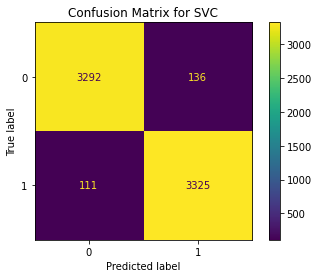

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model1, X_test, Y_test)
disp.ax_.set_title('Confusion Matrix for SVC')
plt.show()

ROC Curve

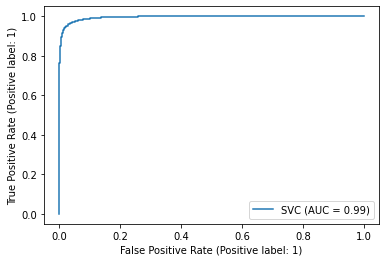

In [ ]:
model1_disp = RocCurveDisplay.from_estimator(model1, X_test, Y_test)
plt.show()

Training the Model: Logistic Regression

In [ ]:
model2 = LogisticRegression()
model2.fit(X_train, Y_train)


LogisticRegression()

Evaluation of accuracy score for Logistic Regression


In [ ]:
# accuracy score on the training data
X_train_prediction = model2.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9776119402985075


In [ ]:
# accuracy score on the test data
X_test_prediction = model2.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9487179487179487


In [ ]:
# F1 score on the test data
X_test_prediction = model2.predict(X_test)
test_data_f1 = f1_score(Y_test, X_test_prediction)

In [ ]:
print('F1 score of the test data : ', test_data_f1)

F1 score of the test data :  0.9492210040392384


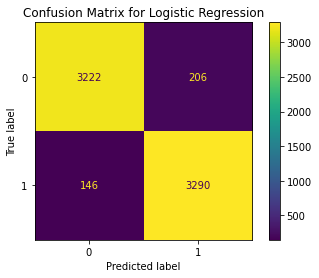

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model2, X_test, Y_test)
disp.ax_.set_title('Confusion Matrix for Logistic Regression')
plt.show()

ROC Curve 

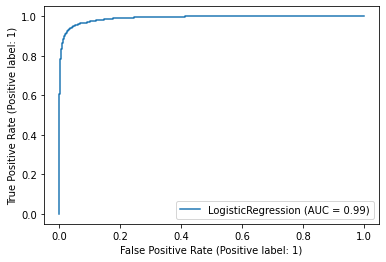

In [ ]:
model2_disp = RocCurveDisplay.from_estimator(model2, X_test, Y_test)
plt.show()

Training the Model: LinearSVC

In [ ]:
model3 = LinearSVC(random_state=0, tol=1e-5)
model3.fit(X_train, Y_train)

LinearSVC(random_state=0, tol=1e-05)


Evaluation of accuracy score for LinearSVC

In [ ]:
# accuracy score on the training data
X_train_prediction = model3.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9993541905855339


In [ ]:
# accuracy score on the test data
X_test_prediction = model3.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9653263403263403


In [ ]:
# F1 score on the test data
X_test_prediction = model3.predict(X_test)
test_data_f1 = f1_score(Y_test, X_test_prediction)

In [ ]:
print('F1 score of the test data : ', test_data_f1)

F1 score of the test data :  0.965606936416185


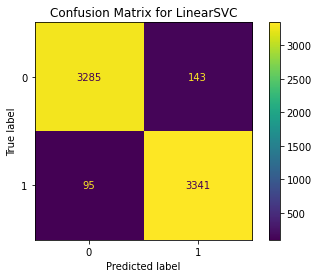

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model3, X_test, Y_test)
disp.ax_.set_title('Confusion Matrix for LinearSVC')
plt.show()

ROC Curve

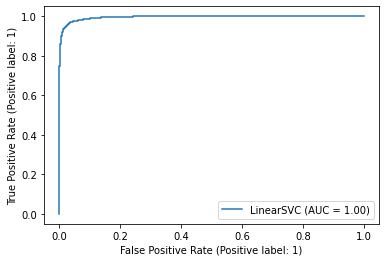

In [ ]:
model3_disp = RocCurveDisplay.from_estimator(model3, X_test, Y_test)
plt.show()

Training the Model: Decision Tree

In [ ]:
model4 = DecisionTreeClassifier()
model4.fit(X_train, Y_train)

DecisionTreeClassifier()

Evaluation of accuracy score for Decision Tree

In [ ]:
# accuracy score on the training data
X_train_prediction = model4.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  1.0


In [ ]:
# accuracy score on the test data
X_test_prediction = model4.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9552738927738927


In [ ]:
# F1 score on the test data
X_test_prediction = model4.predict(X_test)
test_data_f1 = f1_score(Y_test, X_test_prediction)

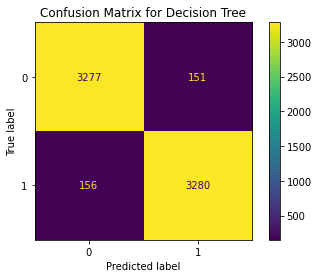

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model4, X_test, Y_test)
disp.ax_.set_title('Confusion Matrix for Decision Tree')
plt.show()

In [ ]:
print('F1 score of the test data : ', test_data_f1)

F1 score of the test data :  0.9552934323576525


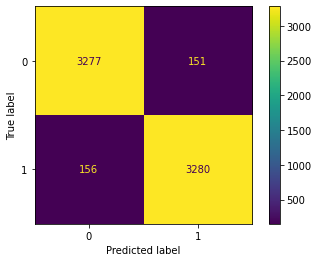

In [ ]:
ConfusionMatrixDisplay.from_estimator(model4, X_test, Y_test)
plt.show()

Training the Model: GradientBoostingClassifier

In [ ]:
model5 = GradientBoostingClassifier(random_state=0)
model5.fit(X_train, Y_train)

GradientBoostingClassifier(random_state=0)

Evaluation of accuracy score for Gradient Boosting

In [ ]:
# accuracy score on the training data
X_train_prediction = model5.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.97050803673938


In [ ]:
# accuracy score on the test data
X_test_prediction = model5.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9613927738927739


In [ ]:
# F1 score on the test data
X_test_prediction = model5.predict(X_test)
test_data_f1 = f1_score(Y_test, X_test_prediction)

In [ ]:
print('F1 score of the test data : ', test_data_f1)

F1 score of the test data :  0.9613646304125966


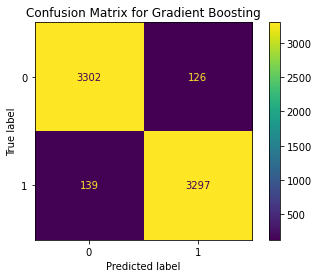

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model5, X_test, Y_test)
disp.ax_.set_title('Confusion Matrix for Gradient Boosting')
plt.show()

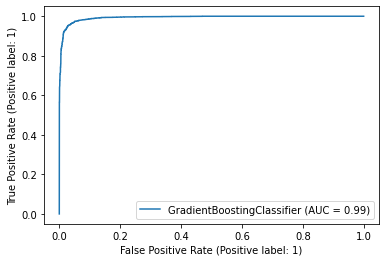

In [ ]:
model5_disp = RocCurveDisplay.from_estimator(model5, X_test, Y_test)
plt.show()

Model : stochastic gradient descent 

In [ ]:
model6 = SGDClassifier()
model6.fit(X_train, Y_train)

SGDClassifier()

In [ ]:
# accuracy score on the training data
X_train_prediction = model6.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9921067738231917


In [ ]:
# accuracy score on the test data
X_test_prediction = model6.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9632867132867133


In [ ]:
# F1 score on the test data
X_test_prediction = model6.predict(X_test)
test_data_f1 = f1_score(Y_test, X_test_prediction)

In [ ]:
print('F1 score of the test data : ', test_data_f1)

F1 score of the test data :  0.9635416666666666


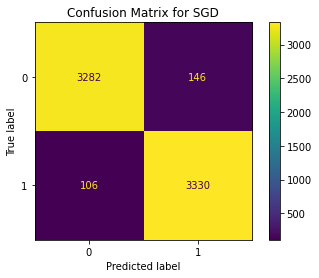

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model6, X_test, Y_test)
disp.ax_.set_title('Confusion Matrix for SGD')
plt.show()

ROC Curve comparison

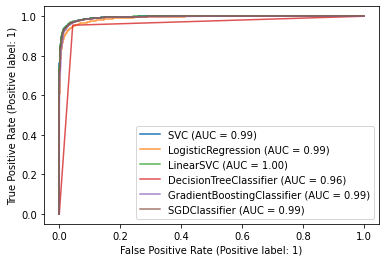

In [ ]:
model1_disp = RocCurveDisplay.from_estimator(model1, X_test, Y_test)
ax = plt.gca()
model2_disp = RocCurveDisplay.from_estimator(model2, X_test, Y_test, ax=ax, alpha=0.8)
ax = plt.gca()
model3_disp = RocCurveDisplay.from_estimator(model3, X_test, Y_test, ax=ax, alpha=0.8)
ax = plt.gca()
model4_disp = RocCurveDisplay.from_estimator(model4, X_test, Y_test, ax=ax, alpha=0.8)
ax = plt.gca()
model5_disp = RocCurveDisplay.from_estimator(model5, X_test, Y_test, ax=ax, alpha=0.8)
ax = plt.gca()
model6_disp = RocCurveDisplay.from_estimator(model6, X_test, Y_test, ax=ax, alpha=0.8)
plt.show()

In [ ]:
X_test = [['I am Kit']] 

X_test = X_test.apply(preprocess)
X_test = vectorizer.transform(X_test)

AttributeError: ignored

Model Selection SVM
https://bit.ly/3OaOO0W
https://bit.ly/3KuFl22

Feature Selection (Backward Stepwise Selection)
https://bit.ly/3NYICc8